## House price prediction using machine learning

**Introduction**

My primary objective is to build a comprehensive exploration of House price prediction using machine learning. From the nitty-gritty of data collection and preprocessing to the nuances of model training. I will apply the below techniques:

1. Data preprocessing
2. Feature selection and engineering
3. Model selection
4. Training
5. Model evaluation and provide visualizations where needed.

**Objectives:**

* A clear explanation of each step will be provided.
* Comments will be provided where needed.
* Reference links will be provided for further investigation.

#### Step 0. Importing all necessary libraries

In [1055]:
# Importing the neccessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

In [1056]:
# Reading in the data

df = pd.read_csv('housing_price.csv')
df.head()

,Unnamed: 0,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
1,2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
2,3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
3,4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
4,5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


#### Step 1. Data Collection and Preprocessing

In [1057]:
# describing the dataset
df.describe(include='all')

,Unnamed: 0,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546,546,546,546,546,546.000000,546
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,yes,no,no,no,no,NaN,no
freq,NaN,NaN,NaN,NaN,NaN,NaN,469,449,355,521,373,NaN,418
mean,273.500000,68121.597070,5150.265568,2.965201,1.285714,1.807692,NaN,NaN,NaN,NaN,NaN,0.692308,NaN
std,157.760895,26702.670926,2168.158725,0.737388,0.502158,0.868203,NaN,NaN,NaN,NaN,NaN,0.861307,NaN
min,1.000000,25000.000000,1650.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,137.250000,49125.000000,3600.000000,2.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
50%,273.500000,62000.000000,4600.000000,3.000000,1.000000,2.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
75%,409.750000,82000.000000,6360.000000,3.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN


> As I see so far, there is a unnamed column in the dataset which lists each observation. I will drop it since it do not adds any value to our model.

In [1058]:
# dropping the firs column
df = df.drop(df.columns[0], axis=1)

In [1059]:
# Checking the info and shape of the dataset along with the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     546 non-null    float64
 1   lotsize   546 non-null    int64  
 2   bedrooms  546 non-null    int64  
 3   bathrms   546 non-null    int64  
 4   stories   546 non-null    int64  
 5   driveway  546 non-null    object 
 6   recroom   546 non-null    object 
 7   fullbase  546 non-null    object 
 8   gashw     546 non-null    object 
 9   airco     546 non-null    object 
 10  garagepl  546 non-null    int64  
 11  prefarea  546 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 51.3+ KB


> For the earlier coding task, I discovered a dataset comprising 546 observations and 13 columns. Notably, there are no null values present. Among these columns, 7 are numerical, while the remaining 6 are categorical.

##### Cheching for duplicates

In [1060]:
# Count of duplicate rows
df.duplicated().sum()

1

> One duplicated rows found. I will filter it to have more info about these duplicated rows

In [1061]:
# Filtering the rows with duplicated values
df[df.duplicated()]

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
534,82000.0,5000,3,1,3,yes,no,no,no,yes,0,no


In [1062]:
# Dropping the duplicated rows
df = df.drop_duplicates()
df.shape

(545, 12)

In [1063]:
# Count of duplicate rows
df.duplicated().sum()

0

##### Checking outliers

> Let's use Interquartile Range (IQR) to see how the outliers are distributed in the dataset. This method focuses on the quartiles of the data distribution. Outliers fall outside the upper and lower bounds calculated using the IQR and a threshold multiplier (typically 1.5). IQR is less sensitive to extreme outliers compared to z-scores and works well for skewed data.

> **Refrences:** [https://www.geeksforgeeks.org/interquartile-range-and-quartile-deviation-using-numpy-and-scipy/](https://www.geeksforgeeks.org/interquartile-range-and-quartile-deviation-using-numpy-and-scipy/)

In [1064]:
# Identifying outliers in each column

def get_outliers(df):
    outliers = {}
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

outliers = get_outliers(df)

In [1065]:
# Dataframe with outliers
outliers_df = pd.DataFrame(outliers.items(), columns=['column_name', 'outliers_count'])
outliers_df = outliers_df.sort_values(by='outliers_count', ascending=False)
outliers_df.head(10)

,column_name,outliers_count
4,stories,41
0,price,15
1,lotsize,12
2,bedrooms,12
5,garagepl,12
3,bathrms,1


> Notice that there are 6 columns with potentially outliers values. Before taking any action, it's important to understand the outliers. Are they genuine data points or are errors is the main question. Let's plot a `Boxplot` before any action.

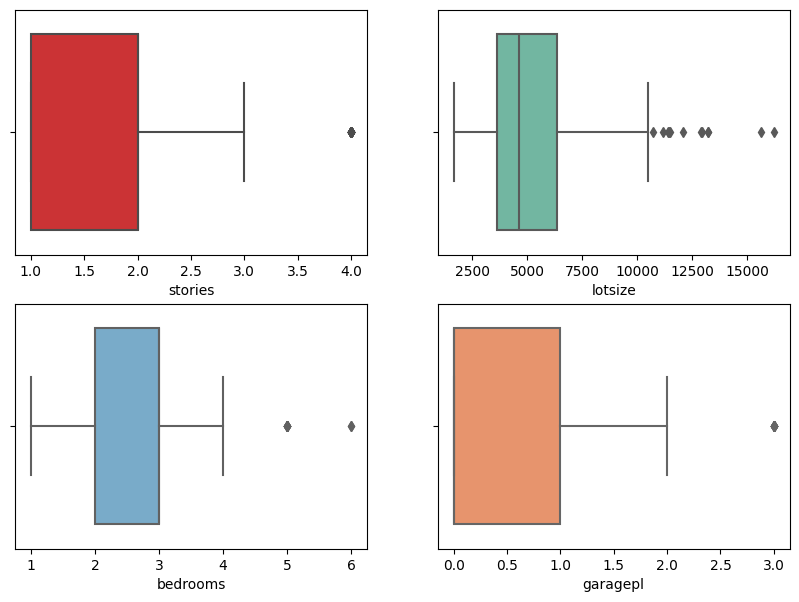

In [1093]:
# Boxplots with outliers
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
sns.boxplot(ax=axes[0, 0], data=df, x='stories', palette='Set1')
sns.boxplot(ax=axes[0, 1], data=df, x='lotsize', palette='Set2')
sns.boxplot(ax=axes[1, 0], data=df, x='bedrooms', palette='Blues_r')
sns.boxplot(ax=axes[1, 1], data=df, x='garagepl', palette='OrRd')
plt.show()

> As I can interpret here so far, all these data points seems to be genuine so I will keep it for now.

#### Step 2. Feature selection and engineering

##### Enconding

> Let's check again the `info()` function to see the datatypes and select the features to encode

In [1067]:
# Checking again the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 0 to 545
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     545 non-null    float64
 1   lotsize   545 non-null    int64  
 2   bedrooms  545 non-null    int64  
 3   bathrms   545 non-null    int64  
 4   stories   545 non-null    int64  
 5   driveway  545 non-null    object 
 6   recroom   545 non-null    object 
 7   fullbase  545 non-null    object 
 8   gashw     545 non-null    object 
 9   airco     545 non-null    object 
 10  garagepl  545 non-null    int64  
 11  prefarea  545 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 55.4+ KB


> So, therea are 6 categorical values as I mentioned before which are:
* `driveway  `
* `recroom   `
* `fullbase     `
* `gashw     `
* `airco     `
* `prefarea  `

Now, for each one I will use `Label Encoding` by leveraging the `LabelEncoder()` function from `sklearn.preprocessing`:

**References:** [https://digestize.medium.com/why-is-using-get-dummies-a-bad-idea-for-your-ml-project-bcfd2683d2e4](https://digestize.medium.com/why-is-using-get-dummies-a-bad-idea-for-your-ml-project-bcfd2683d2e4)

In [1068]:
# Using label encoder to encode the categorical columns
from sklearn.calibration import LabelEncoder

# Encoding the categorical columns
le = LabelEncoder()
df['driveway'] = le.fit_transform(df['driveway'])
df['recroom'] = le.fit_transform(df['recroom'])
df['fullbase'] = le.fit_transform(df['fullbase'])
df['gashw'] = le.fit_transform(df['gashw'])
df['airco'] = le.fit_transform(df['airco'])
df['prefarea'] = le.fit_transform(df['prefarea'])

# Checking the info again
df.head()

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,42000.0,5850,3,1,2,1,0,1,0,0,1,0
1,38500.0,4000,2,1,1,1,0,0,0,0,0,0
2,49500.0,3060,3,1,1,1,0,0,0,0,0,0
3,60500.0,6650,3,1,2,1,1,0,0,0,0,0
4,61000.0,6360,2,1,1,1,0,0,0,0,0,0


> Now I have all the categorical features encoded with binary values.  
Next step for me is to check multicollinearity between features to drop if necessary. To do so, I will plot a heat map using the independent variables or predictors.

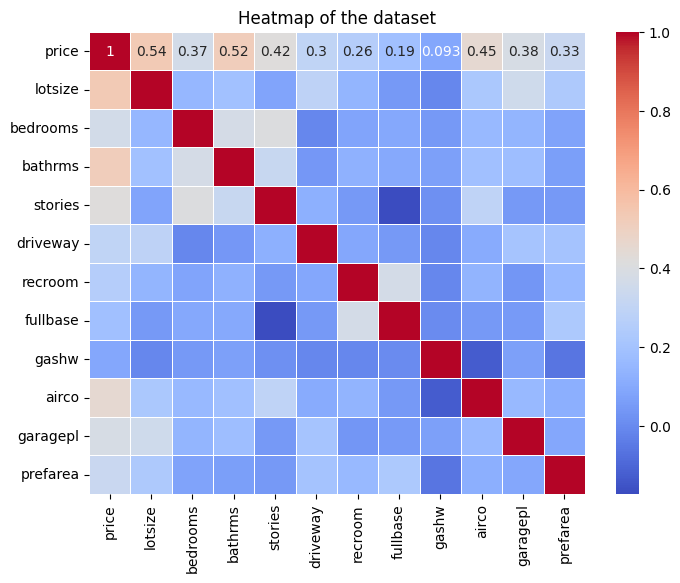

In [1069]:
# Heatmap of the dataset

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidth=.5) 
plt.title('Heatmap of the dataset')
plt.show()


> Leveraging the insights of the previous heatmap I found little correlation between the `gashw` predictor with the outcome variable `price`. So, for these very weak correlations to the target variable (house price) my decision is to drop it.

In [1070]:
# Droping the two week variables
df = df.drop(['gashw'], axis=1)

#### 3. Model selection

> Before proceding I have to choose at least two model options to perform a training and select a metric to choose the winner which performs better.  
I will focus on `Multiple Linear Regression` and `Ramdom Forest` models.  

> Why?  
Multiple Linear Regression: Aka multivariable linear regression. This is applicable when there are many predictor variables. An example of this is predicting wine prices. This depends on mean growing season temperature, harvest rainfall, winter rainfall, and more.

>Random Forest is a powerful, yet relatively simple, data mining and supervised machine learning technique. It allows quick and automatic identification of relevant information from extremely large datasets. The biggest strength of the algorithm is that it relies on the collection of many predictions (trees) rather than trusting a single one. With Random Forest you can do:
>- Classification (input = categorical data), each tree casts a vote for the final prediction.
>- Regression (input= continuous data), the tree’s results are averaged to create the final prediction.

**References:** 
* [https://devopedia.org/linear-regression](https://devopedia.org/linear-regression)
* [https://towardsdatascience.com/quick-intro-to-random-forest-3cb5006868d8](https://towardsdatascience.com/quick-intro-to-random-forest-3cb5006868d8)

#### 4. Model Trainning

##### Splitting the data

In [1071]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into features and target variable
X = df.drop('price', axis=1)
y = df['price']

# Splitting the dataset into the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


##### Scaling the data

> Before continuing it will be a good idea to scale the data given that I have different scales and I want them to contibute equally during the model trainning.

> There are two common scaling methods:
>* StandardScaler: This method standardizes features by removing the mean and scaling to unit variance. It's a good choice when the features have different scales and you want them to contribute equally during model training.
>* MinMaxScaler: This method scales each feature to a range between 0 and 1 (or a custom range you specify). It can be useful when the data has outliers or when the features have significantly different scales, but you want to preserve the original distribution of the data.

**Reference:** [https://www.analyticsvidhya.com/blog/2020/12/feature-engineering-feature-improvements-scaling/](https://www.analyticsvidhya.com/blog/2020/12/feature-engineering-feature-improvements-scaling/)

In [1072]:
# Importing the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Scaling the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


> At this point, I have to consider the metrics I will use to determine which model is a better fit to predict house price.  
For regression problems and models three metrics are suitable: `Mean Squared Error MSE`, `Root Mean Squared Error RMSE`, and `R Squared R2`.

> **Reference:**  [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

##### Trainning the model

In this step, I will defina a function as a Pipeline to improve code reusability. I took this part from the **LinkedIn Learning** course  
`Artificial Intelligence Foundations: Machine Learning` that I recently complete. 

**Reference:** [https://www.linkedin.com/learning/artificial-intelligence-foundations-machine-learning-22345868/introduction-to-ai-foundations-machine-learning-course?u=56968457](https://www.linkedin.com/learning/artificial-intelligence-foundations-machine-learning-22345868/introduction-to-ai-foundations-machine-learning-course?u=56968457)

In [1073]:
# implementing a linear regression model
from sklearn.metrics import mean_squared_error, r2_score

# Data Pipleine

'''So here we are going to create a function that will take in a model and fit it to the training data and then make predictions on the testing data.
The function will also evaluate the model using the mean squared error, root mean squared error and the R2 score.'''

def fit_model (model):

    # Fitting the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Evaluating the model with the MSE, RMSE and R2 score
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results = pd.DataFrame({'Model': [model], 'Mean Squared Error': [mse], 'Root Mean Squared Error': [rmse], 'R2 Score': [r2]})
    return results


In [1074]:
# implementing a decision tree model
from sklearn.tree import DecisionTreeRegressor

# Creating an instance of the model
model2 = DecisionTreeRegressor()

# Fitting the model
fit_model(model2)


,Model,Mean Squared Error,Root Mean Squared Error,R2 Score
0,DecisionTreeRegressor(),4.359075e+08,20878.398894,0.469458


In [1075]:
# implementing a random forest model
from sklearn.ensemble import RandomForestRegressor

# Creating an instance of the model
model3 = RandomForestRegressor()

# Fitting the model
fit_model(model3)

,Model,Mean Squared Error,Root Mean Squared Error,R2 Score
0,"(DecisionTreeRegressor(max_features=1.0, rando...",2.429338e+08,15586.332526,0.704326


In [1076]:
# implementing a linear regression model
from sklearn.linear_model import LinearRegression

# Creating an instance of the model
model1 = LinearRegression()

# Fitting the model
fit_model(model1)

,Model,Mean Squared Error,Root Mean Squared Error,R2 Score
0,LinearRegression(),2.104320e+08,14506.276146,0.743883


#### 5. Model evaluation and provide visualizations where needed.

> From the previous training step we got a higher score while evaluating the `Linear Regression model` as follows:  
* `MSE: `  2.104320e+08
* `RMSE:` 14506.2 
* `R2:` 0.743883

> In conclusion, the Linear Regression model performs better than the others


##### Visualization

> One visualization I want ot use to conclude, is a Scatter Plot using Actual vs. Predicted Prices, which helps to visualize how well the model's predictions align with the actual values. Ideally, most points should fall close to a diagonal line (perfect prediction).  

> I will use a `Regplot` as metioned in the seaborn documentation.

**Reference:** [https://seaborn.pydata.org/generated/seaborn.regplot.html](https://seaborn.pydata.org/generated/seaborn.regplot.html)

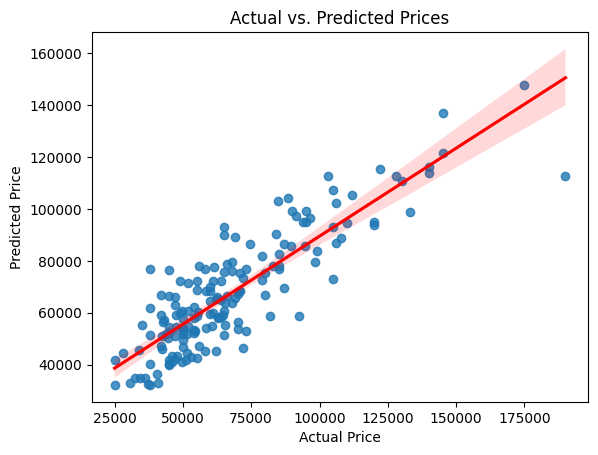

In [1077]:
# regplot of the actual vs predicted prices
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")
plt.show()

#### **Conclusion:**

The scatter plot (actual vs. predicted prices) reveals a positive linear relationship between the predicted and actual house prices. The data points cluster closely around a diagonal line, indicating a strong positive correlation. This suggests that the model is effectively capturing the linear trends in the data and can predict house prices with reasonable accuracy within the observed range."
